# COURSE: A deep understanding of deep learning

## SECTION: ANNs

### LECTURE: Model depth vs. breadth

#### TEACHER: Mike X Cohen, sincxpress.com

##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210


In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


# Import and organize the data


In [2]:
# import dataset (comes with seaborn)
import seaborn as sns

iris = sns.load_dataset("iris")

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2


# Construct and sanity-check the model


In [6]:
# create a class for the model


class ANNiris(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create dictionary to store the layers
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers  # nLayers#

        ### input layer
        self.layers["input"] = nn.Linear(4, nUnits)

        ### hidden layers
        for i in range(nLayers):
            self.layers[f"hidden{i}"] = nn.Linear(nUnits, nUnits)

        ### output layer
        self.layers["output"] = nn.Linear(nUnits, 3)

    # forward pass
    def forward(self, x):
        # input layer (note: the code in the video omits the relu after this layer)
        x = F.relu(self.layers["input"](x))

        # hidden layers
        for i in range(self.nLayers):
            x = F.relu(self.layers[f"hidden{i}"](x))

        # return output layer
        x = self.layers["output"](x)
        return x


In [7]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 12
nLayers = 4
net = ANNiris(nUnitsPerLayer, nLayers)
net


ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [8]:
# A quick test of running some numbers through the model.
# This simply ensures that the architecture is internally consistent.


# 10 samples, 4 dimensions
tmpx = torch.randn(10, 4)

# run it through the DL
y = net(tmpx)

# exam the shape of the output
print(y.shape), print(" ")

# and the output itself
print(y)


torch.Size([10, 3])
 
tensor([[-0.1743,  0.3083,  0.1483],
        [-0.1755,  0.3073,  0.1481],
        [-0.1699,  0.3119,  0.1486],
        [-0.1468,  0.3261,  0.1438],
        [-0.1762,  0.3071,  0.1478],
        [-0.1670,  0.3141,  0.1488],
        [-0.1731,  0.3095,  0.1481],
        [-0.1759,  0.3071,  0.1480],
        [-0.1684,  0.3128,  0.1490],
        [-0.1597,  0.3163,  0.1473]], grad_fn=<AddmmBackward0>)


# Create a function that trains the model


In [9]:
# a function to train the model


def trainTheModel(theModel):

    # define the loss function and optimizer
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(theModel.parameters(), lr=0.01)

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = theModel(data)

        # compute loss
        loss = lossfun(yHat, labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass to get accuracy
    predictions = theModel(data)
    predlabels = torch.argmax(predictions, axis=1)
    acc = 100 * torch.mean((predlabels == labels).float())

    # total number of trainable parameters in the model
    nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

    # function outputs
    return acc, nParams


In [10]:
# test the function once

numepochs = 2500
acc = trainTheModel(net)

# check the outputs
acc  # tuple containing (accuracy,nparams)


(tensor(96.6667), 723)

# Now for the experiment!


In [11]:
# this cell takes ~2 mins

# define the model parameters
numlayers = range(1, 6)  # number of hidden layers
numunits = np.arange(4, 101, 3)  # units per hidden layer

# initialize output matrices
accuracies = np.zeros((len(numunits), len(numlayers)))
totalparams = np.zeros((len(numunits), len(numlayers)))

# number of training epochs
numepochs = 500


# start the experiment!
for unitidx in range(len(numunits)):
    for layeridx in range(len(numlayers)):

        # create a fresh model instance
        net = ANNiris(numunits[unitidx], numlayers[layeridx])

        # run the model and store the results
        acc, nParams = trainTheModel(net)
        accuracies[unitidx, layeridx] = acc

        # store the total number of parameters in the model
        totalparams[unitidx, layeridx] = nParams


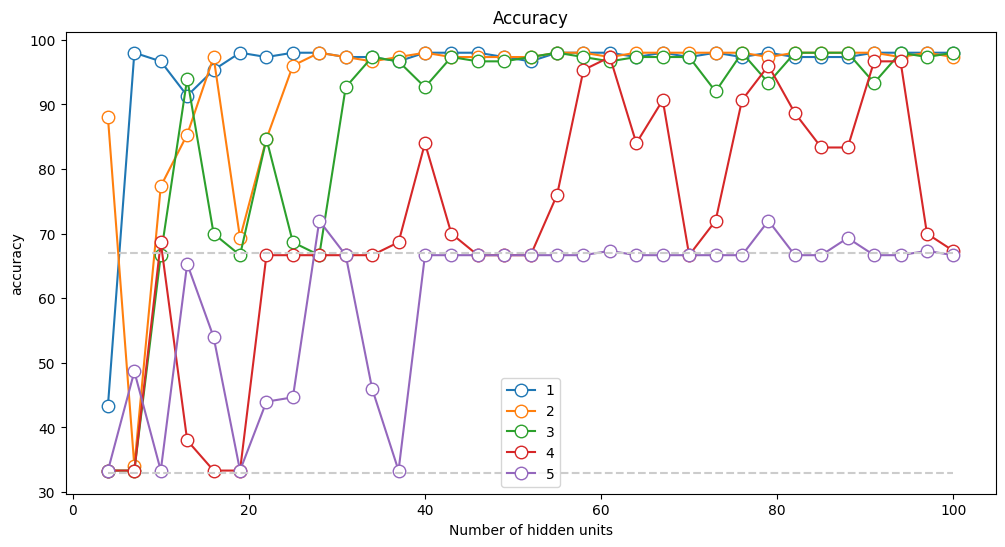

In [12]:
# show accuracy as a function of model depth
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(numunits, accuracies, "o-", markerfacecolor="w", markersize=9)
ax.plot(numunits[[0, -1]], [33, 33], "--", color=[0.8, 0.8, 0.8])
ax.plot(numunits[[0, -1]], [67, 67], "--", color=[0.8, 0.8, 0.8])
ax.legend(numlayers)
ax.set_ylabel("accuracy")
ax.set_xlabel("Number of hidden units")
ax.set_title("Accuracy")
plt.show()


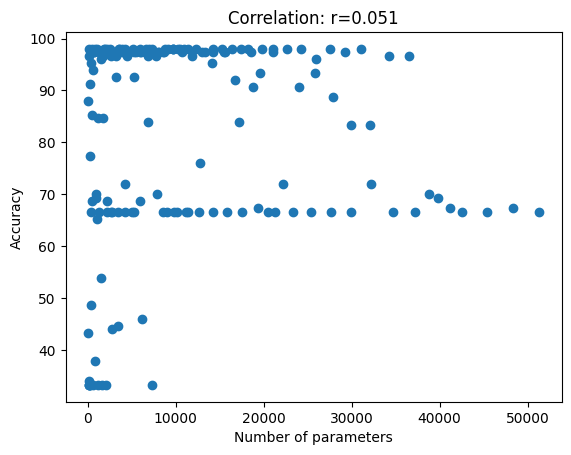

In [13]:
# Maybe it's simply a matter of more parameters -> better performance?

# vectorize for convenience
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x, y)[0, 1]

# scatter plot
plt.plot(x, y, "o")
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.title("Correlation: r=" + str(np.round(r, 3)))
plt.show()


# Additional explorations


In [ ]:
# 1) Try it again with 1000 training epochs. Do the deeper models eventually learn?
#
# 2) The categories are coded a "0", "1", and "2". Is there something special about those numbers?
#    Recode the labels to be, e.g., 5, 10, and 17. Or perhaps -2, 0, and 2. Is the model still able to learn?
#
